# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
!pip install imblearn

In [2]:
!pip install xgboost
from xgboost import XGBClassifier

In [3]:
#!pip3 install --upgrade pandas

In [4]:
!pip install lightgbm

In [5]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTETomek
from sklearn.metrics import precision_score
from sklearn import metrics
import time
from timeit import default_timer as timer
from datetime import timedelta
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from cycler import cycler

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [6]:
# *run only when in Udacity environment*
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [7]:
# *run only when in local environment*
start = timer()
azdias = pd.read_csv(r'C:\Users\amiri\OneDrive\Education\MLND\Capstone Project\Notebooks\azdias.csv')
customers = pd.read_csv(r'C:\Users\amiri\OneDrive\Education\MLND\Capstone Project\Notebooks\customers.csv')
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

C:\Users\amiri\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Execution time HH:MM:SS: 0:00:42.376390


In [8]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [9]:
print(azdias.shape)
azdias.head()

(891221, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [10]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [11]:
print(customers.shape)
customers.head()

(191652, 369)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


Total empty cells (azdias): 33492923
Total empty cells (customers): 13864522
Wall time: 9.68 s


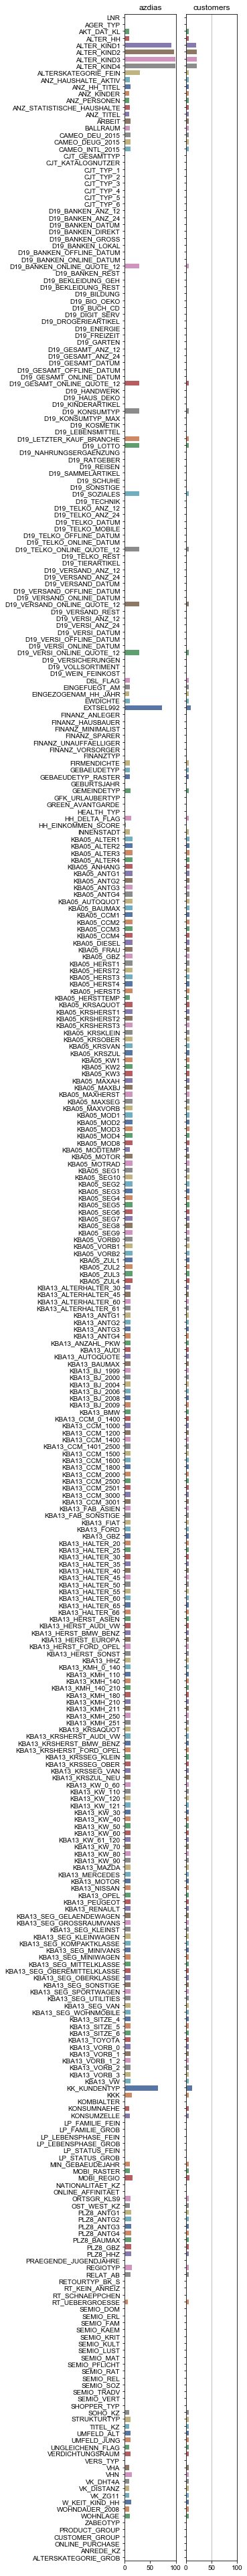

In [12]:
%%time

print('Total empty cells (azdias):', azdias.isnull().sum().sum())
print('Total empty cells (customers):', customers.isnull().sum().sum())

missing_data_azdias = pd.Series((azdias.isnull().sum()/len(azdias))*100)
missing_data_customers = pd.Series((customers.isnull().sum()/len(azdias))*100)

fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(3,70))
ax.invert_xaxis()
ax.title.set_text('azdias')
ax2.title.set_text('customers')
#ax.yaxis.tick_right() # put labels for left graph on right or in between the two graphs, cannot scale correctly
ax.set(xlim=(0, 100))
ax2.set(xlim=(0, 100))
plt.grid(b=True, axis='x')

sns.set(style="whitegrid")
sns.barplot(x=missing_data_azdias, y=missing_data_azdias.index, palette='deep', ax=ax)
sns.barplot(x=missing_data_customers, y=missing_data_customers.index, palette='deep', ax=ax2)


In [13]:
# inspect columns
miss_percent_col = 30 # 1-100
miss_data_col_az = missing_data_azdias[missing_data_azdias >=miss_percent_col]
miss_data_col_cust = missing_data_customers[missing_data_customers >=miss_percent_col]
print('Number of columns missing >= % 2d%% (azdias): ' %(miss_percent_col), len(miss_data_col_az))
print('Number of columns missing >= % 2d%%  (customers): ' %(miss_percent_col), len(miss_data_col_cust))
print('Percent of missing to total (azdias): ', (len(miss_data_col_az)/len(azdias.columns)*100))
print('Percent of missing to total (customers): ', (len(miss_data_col_cust)/len(azdias.columns)*100))
print()
print('Missing data azdias: \n', miss_data_col_az)
print()
print('Missing data customers: \n', miss_data_col_cust)

Number of columns missing >=  30% (azdias):  6
Number of columns missing >=  30%  (customers):  0
Percent of missing to total (azdias):  1.639344262295082
Percent of missing to total (customers):  0.0

Missing data azdias: 
 ALTER_KIND1     90.904837
ALTER_KIND2     96.690047
ALTER_KIND3     99.307691
ALTER_KIND4     99.864792
EXTSEL992       73.399639
KK_KUNDENTYP    65.596749
dtype: float64

Missing data customers: 
 Series([], dtype: float64)


In [14]:
# columns to be deleted - by default, always use azdias
col_to_delete_az = miss_data_col_az.index.values.tolist()
col_to_delete_cust = miss_data_col_cust.index.values.tolist()
print(type(col_to_delete_az))
print(col_to_delete_az)

<class 'list'>
['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']


In [15]:
def inspect_rows(df, missing_percent_row=30):
    ''' inspect rows and report back how many rows are missing n% of data and what percentage of all rows that is
    '''
    missing_percent_row = missing_percent_row # 1-100
    missing_data_rows = list(df[df.isnull().sum(axis=1) > missing_percent_row].index)

    print('Number of rows missing >= % 2d%%: ' %(missing_percent_row), len(missing_data_rows))
    print('Percent of missing to total: ', (len(missing_data_rows)/len(df)*100))
    print()
    
    return missing_data_rows

In [16]:
%%time
missing_data_rows_az = inspect_rows(azdias, missing_percent_row=30)

Number of rows missing >=  30%:  140637
Percent of missing to total:  15.780261012700553

Wall time: 2.71 s


In [17]:
%%time
missing_data_rows_cust = inspect_rows(customers, missing_percent_row=30)

Number of rows missing >=  30%:  56608
Percent of missing to total:  29.536868908229497

Wall time: 648 ms


### Part 0.1: Browse, Preprocess and Clean

I create functions here so that I can be called from anywhere and for any dataset. In this section, I also drop columns that are not needed.

In [18]:
def data_preprocess_clean(df, operation='col', delete_rows=None):
    '''  
    This function takes in either the azdias, customers, mailout_train, and mailout_test data and preprocessess it
    by dropping columns that are not useful to the analysis and returns the processed data as df_drop.
    df: dataframe of azdias or customers that gets loaded in the cell above
    operation: 'col' - processes columns only, 'both' processes 
    '''
    df_clean=pd.DataFrame()

    # process COLUMNS - drop columns that are missing too many values
    if operation in ['col', 'both']:
        print('- processing columns')
        print('rows, columns (before): ',df.shape)
        df_clean = df.drop(col_to_delete_az, inplace=False, axis=1) # drop columns that are missing too much data
        print('rows, columns (after): ',df_clean.shape)

    # process ROWS - drop rows that are missing too many values
    if operation in ['both'] and delete_rows != None: 
        print('- processing rows')
        print('rows, columns (before): ',df_clean.shape)
        df_clean.drop(delete_rows, inplace=True, axis=0) # drop columns that are missing too much data
        print('rows, columns (after): ',df_clean.shape)
        # ***if rows are processed, do i need to combine azdias/customers first?***
    
    # frequent value fill - fill empty cells with most frequent value for each column 
    print('- filling empty cells with most frequent value for each column')
    df_clean = df_clean.apply(lambda x:x.fillna(x.value_counts().index[0]))
    
    # if present, delete this col that somehow gets added 
    #if df_clean.columns[0] == 'Unnamed: 0':
        #df_clean.drop(['Unnamed: 0'], inplace=True, axis=1) # probably more efficient method, or way to not add it
    
    # delete this col that contains date/time stamp 
    if 'EINGEFUEGT_AM'in df_clean:
        df_clean.drop('EINGEFUEGT_AM', inplace=True, axis=1) 
        
    if 'D19_LETZTER_KAUF_BRANCHE'in df_clean:
        df_clean.drop('D19_LETZTER_KAUF_BRANCHE', inplace=True, axis=1)
    
    if 'OST_WEST_KZ'in df_clean:
        print('- one hot encoding for OST_WEST_KZ and CAMEO_DEU_2015')
        # one hot encoding - 'OST_WEST_KZ', 
        column =df_clean['OST_WEST_KZ']
        #values for OST_WEST_KZ
        ost_west_kz ='OW' #OST_WEST_KZ - "W" or "O"
        # define mapping of chars to integers
        char_to_int = dict((c, i) for i, c in enumerate(ost_west_kz))
        # integer encode input data
        integer_encoded = [char_to_int[char] for char in column]
        df_clean['OST_WEST_KZ'] = integer_encoded
    
    if 'CAMEO_DEU_2015' in df_clean:
        # one hot encoding - 'CAMEO_DEU_2015'
        data = df_clean['CAMEO_DEU_2015']
        values = array(data)
        # integer encode
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(values)
        df_clean['CAMEO_DEU_2015'] = integer_encoded
    
    # remove "X" and "XX" from: 'CAMEO_DEU_2015' 'CAMEO_DEUG_2015' 'CAMEO_INTL_2015' columns and replace w/most freqent
    if 'CAMEO_DEU_2015'in df_clean:
        print('- replacing "X" and "XX" in CAMEO_DEU_2015 column w/most frequent of column')
        cameo_deu_2015 = df_clean['CAMEO_DEU_2015'].value_counts().idxmax()
        df_clean['CAMEO_DEU_2015'] = df_clean['CAMEO_DEU_2015'].replace(['X', 'XX'], cameo_deu_2015)
        
    if 'CAMEO_DEUG_2015' in df_clean:
        print('- replacing "X" and "XX" in CAMEO_DEUG_2015 column w/most frequent of column')
        cameo_deug_2015 = df_clean['CAMEO_DEUG_2015'].value_counts().idxmax()
        df_clean['CAMEO_DEUG_2015'] = df_clean['CAMEO_DEUG_2015'].replace(['X', 'XX'], cameo_deug_2015)
        
    if 'CAMEO_INTL_2015' in df_clean:
        print('- replacing "X" and "XX" in CAMEO_INTL_2015 column w/most frequent of column')
        cameo_intl_2015 = df_clean['CAMEO_INTL_2015'].value_counts().idxmax()
        df_clean['CAMEO_INTL_2015'] = df_clean['CAMEO_INTL_2015'].replace(['X', 'XX'], cameo_intl_2015)
    
    return df_clean

In [19]:
%%time
azdias_clean = data_preprocess_clean(azdias, operation='both', delete_rows=missing_data_rows_az)

- processing columns
rows, columns (before):  (891221, 366)
rows, columns (after):  (891221, 360)
- processing rows
rows, columns (before):  (891221, 360)
rows, columns (after):  (750584, 360)
- filling empty cells with most frequent value for each column
- one hot encoding for OST_WEST_KZ and CAMEO_DEU_2015
- replacing "X" and "XX" in CAMEO_DEU_2015 column w/most frequent of column
- replacing "X" and "XX" in CAMEO_DEUG_2015 column w/most frequent of column
- replacing "X" and "XX" in CAMEO_INTL_2015 column w/most frequent of column
Wall time: 3min 36s


In [20]:
azdias_clean.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,-1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,...,0.0,7.0,10.0,11.0,6.0,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


In [21]:
# customers - call data_preprocess_clean function, print using .head() to view sample of results

customers_clean = data_preprocess_clean(customers, operation='both',  delete_rows=missing_data_rows_cust)
customers_clean = customers_clean.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=False, axis=1)
print('rows, columns (after dropping the 3 extra columns): ', customers_clean.shape)
customers_clean.head()

- processing columns
rows, columns (before):  (191652, 369)
rows, columns (after):  (191652, 363)
- processing rows
rows, columns (before):  (191652, 363)
rows, columns (after):  (135044, 363)
- filling empty cells with most frequent value for each column
- one hot encoding for OST_WEST_KZ and CAMEO_DEU_2015
- replacing "X" and "XX" in CAMEO_DEU_2015 column w/most frequent of column
- replacing "X" and "XX" in CAMEO_DEUG_2015 column w/most frequent of column
- replacing "X" and "XX" in CAMEO_INTL_2015 column w/most frequent of column
rows, columns (after dropping the 3 extra columns):  (135044, 358)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
2,143872,-1,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,8.0,0.0,0.0,0.0,0.0,1.0,...,2.0,6.0,4.0,2.0,6.0,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3
5,143888,1,1.0,11.0,10.0,1.0,0.0,0.0,2.0,1.0,...,4.0,1.0,2.0,1.0,6.0,9.0,1.0,2,1,3


In [22]:
#customers_clean.to_csv('customers_clean.csv', index=False)

In [23]:
# azdias - list of remaining features

features_list_azdias = azdias_clean.columns.values
print('number of remaining features (general population): ', len(features_list_azdias))
print('Features: \n', features_list_azdias)

number of remaining features (general population):  358
Features: 
 ['LNR' 'AGER_TYP' 'AKT_DAT_KL' 'ALTER_HH' 'ALTERSKATEGORIE_FEIN'
 'ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL' 'ANZ_KINDER' 'ANZ_PERSONEN'
 'ANZ_STATISTISCHE_HAUSHALTE' 'ANZ_TITEL' 'ARBEIT' 'BALLRAUM'
 'CAMEO_DEU_2015' 'CAMEO_DEUG_2015' 'CAMEO_INTL_2015' 'CJT_GESAMTTYP'
 'CJT_KATALOGNUTZER' 'CJT_TYP_1' 'CJT_TYP_2' 'CJT_TYP_3' 'CJT_TYP_4'
 'CJT_TYP_5' 'CJT_TYP_6' 'D19_BANKEN_ANZ_12' 'D19_BANKEN_ANZ_24'
 'D19_BANKEN_DATUM' 'D19_BANKEN_DIREKT' 'D19_BANKEN_GROSS'
 'D19_BANKEN_LOKAL' 'D19_BANKEN_OFFLINE_DATUM' 'D19_BANKEN_ONLINE_DATUM'
 'D19_BANKEN_ONLINE_QUOTE_12' 'D19_BANKEN_REST' 'D19_BEKLEIDUNG_GEH'
 'D19_BEKLEIDUNG_REST' 'D19_BILDUNG' 'D19_BIO_OEKO' 'D19_BUCH_CD'
 'D19_DIGIT_SERV' 'D19_DROGERIEARTIKEL' 'D19_ENERGIE' 'D19_FREIZEIT'
 'D19_GARTEN' 'D19_GESAMT_ANZ_12' 'D19_GESAMT_ANZ_24' 'D19_GESAMT_DATUM'
 'D19_GESAMT_OFFLINE_DATUM' 'D19_GESAMT_ONLINE_DATUM'
 'D19_GESAMT_ONLINE_QUOTE_12' 'D19_HANDWERK' 'D19_HAUS_DEKO'
 'D19_KINDE

In [24]:
# customers - list of remaining features

features_list_customers = customers_clean.columns.values
print(type(features_list_customers))
print('number of remaining features (customers): ', len(features_list_customers))
print('Features: \n', features_list_customers)

<class 'numpy.ndarray'>
number of remaining features (customers):  358
Features: 
 ['LNR' 'AGER_TYP' 'AKT_DAT_KL' 'ALTER_HH' 'ALTERSKATEGORIE_FEIN'
 'ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL' 'ANZ_KINDER' 'ANZ_PERSONEN'
 'ANZ_STATISTISCHE_HAUSHALTE' 'ANZ_TITEL' 'ARBEIT' 'BALLRAUM'
 'CAMEO_DEU_2015' 'CAMEO_DEUG_2015' 'CAMEO_INTL_2015' 'CJT_GESAMTTYP'
 'CJT_KATALOGNUTZER' 'CJT_TYP_1' 'CJT_TYP_2' 'CJT_TYP_3' 'CJT_TYP_4'
 'CJT_TYP_5' 'CJT_TYP_6' 'D19_BANKEN_ANZ_12' 'D19_BANKEN_ANZ_24'
 'D19_BANKEN_DATUM' 'D19_BANKEN_DIREKT' 'D19_BANKEN_GROSS'
 'D19_BANKEN_LOKAL' 'D19_BANKEN_OFFLINE_DATUM' 'D19_BANKEN_ONLINE_DATUM'
 'D19_BANKEN_ONLINE_QUOTE_12' 'D19_BANKEN_REST' 'D19_BEKLEIDUNG_GEH'
 'D19_BEKLEIDUNG_REST' 'D19_BILDUNG' 'D19_BIO_OEKO' 'D19_BUCH_CD'
 'D19_DIGIT_SERV' 'D19_DROGERIEARTIKEL' 'D19_ENERGIE' 'D19_FREIZEIT'
 'D19_GARTEN' 'D19_GESAMT_ANZ_12' 'D19_GESAMT_ANZ_24' 'D19_GESAMT_DATUM'
 'D19_GESAMT_OFFLINE_DATUM' 'D19_GESAMT_ONLINE_DATUM'
 'D19_GESAMT_ONLINE_QUOTE_12' 'D19_HANDWERK' 'D19_HAUS_DE

In [25]:
# do the feature lists of azdias and customers match?

import collections
equal = collections.Counter(features_list_azdias) == collections.Counter(features_list_customers)
print('features lists of azdias and customers are equal?: ', equal)

features lists of azdias and customers are equal?:  True


### Part 0.2: Visualize the Data

I Created histograms of some of the general population data and the customers data. I also Normalized data using StandardScaler().

C:\Users\amiri\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\amiri\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\amiri\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


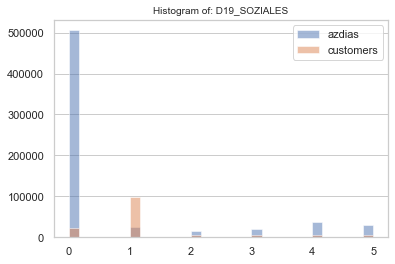

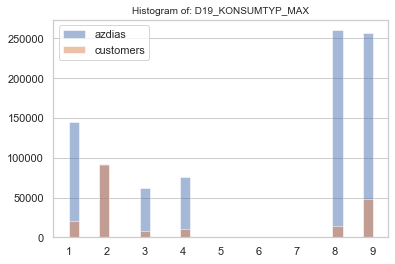

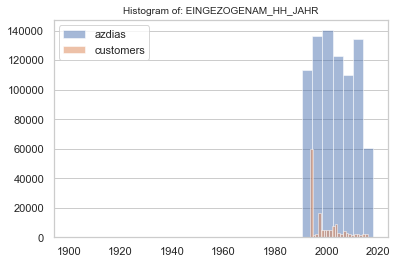

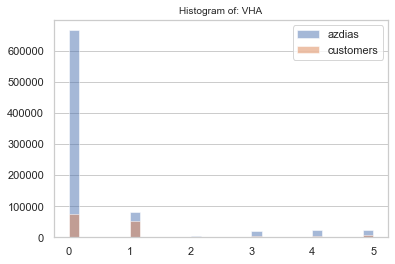

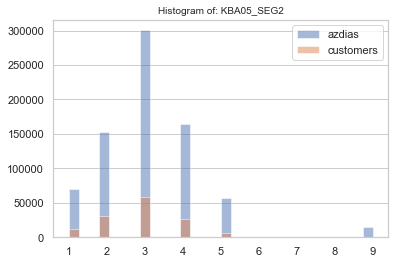

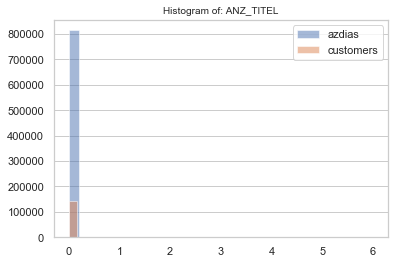

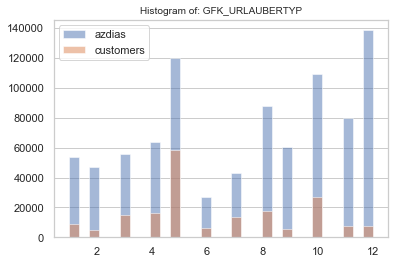

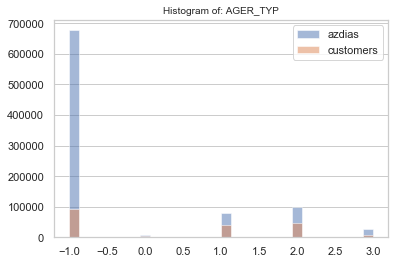

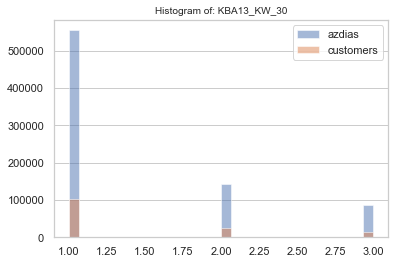

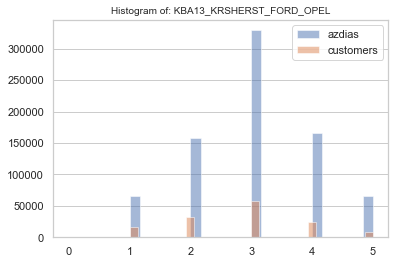

In [26]:
x = azdias
y = customers
n_bins = 30
feature_list = ['D19_SOZIALES', 'D19_KONSUMTYP_MAX', 'EINGEZOGENAM_HH_JAHR', 'VHA', 'KBA05_SEG2', 'ANZ_TITEL'\
                ,'GFK_URLAUBERTYP', 'AGER_TYP', 'KBA13_KW_30', 'KBA13_KRSHERST_FORD_OPEL']


for column_name in feature_list:
    title="Histogram of: " + column_name
    plt.hist(x[column_name], bins=n_bins, alpha=0.5, label='azdias')
    plt.hist(y[column_name], bins=n_bins, alpha=0.5, label='customers')
    plt.title(title, fontsize=10)
    plt.legend(loc='best')
    ax = plt.axes()
    plt.grid(b=True, axis='x')
    ax.xaxis.grid() # horizontal lines
 
    plt.show()

In [27]:
# normalize the data using StandardScaler()
# (could include MinMaxScaler so that all values fall between 0 and 1)

# azdias
azdias_scaled = StandardScaler().fit_transform(azdias_clean)
print('datatype of azdias_scaled: ', type(azdias_scaled))

# customers
customers_scaled = StandardScaler().fit_transform(customers_clean)
print('datatype of customers_scaled: ', type(customers_scaled))

datatype of azdias_scaled:  <class 'numpy.ndarray'>
datatype of customers_scaled:  <class 'numpy.ndarray'>


In [28]:
# convert azdias_scaled and customers_scaled to df and then restore column (feature) names after scaling

azdias_scaled_df = pd.DataFrame(azdias_scaled)
customers_scaled_df = pd.DataFrame(customers_scaled)
customers_scaled_df.columns = customers_scaled_df.columns=features_list_customers
azdias_scaled_df.columns = azdias_scaled_df.columns=features_list_azdias

azdias_scaled_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.059934,-0.572976,1.249385,-1.417122,1.561990,0.159131,-0.128335,-0.296889,0.233209,0.292359,...,1.367366,0.681677,1.055467,1.452333,-0.601791,0.548457,-0.028541,1.139246,0.957598,-1.684797
1,1.059954,-0.572976,1.249385,0.809429,0.676063,0.095282,-0.128335,-0.296889,-0.626902,-0.054891,...,-0.359346,1.031522,0.441264,0.018143,-0.601791,0.548457,-1.085620,1.139246,0.957598,0.164107
2,1.059958,1.857987,-0.942531,0.285534,-0.209865,-0.479360,-0.128335,-0.296889,-1.487012,-0.402141,...,-2.086057,0.331832,0.748366,1.810881,0.981840,0.548457,1.557078,-0.284790,0.957598,1.088559
3,1.060016,-0.572976,-0.942531,1.202350,0.011617,-0.351662,-0.128335,-0.296889,1.953430,-0.332691,...,-0.359346,-1.067550,-0.787142,-0.698953,-1.129668,0.548457,-0.557080,0.427228,-1.044279,0.164107
4,1.060027,2.668309,-0.942531,-0.107386,-0.874310,-0.223963,-0.128335,-0.296889,-0.626902,-0.402141,...,-0.359346,1.381368,-0.172939,-0.698953,0.981840,0.548457,1.557078,0.427228,0.957598,-1.684797


In [29]:
# run .describe() for customers

customers_scaled_df.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,1.350440e+05,1.350440e+05,1.350440e+05,1.350440e+05,1.350440e+05,1.350440e+05,1.350440e+05,1.350440e+05,1.350440e+05,1.350440e+05,...,1.350440e+05,1.350440e+05,1.350440e+05,1.350440e+05,1.350440e+05,1.350440e+05,1.350440e+05,1.350440e+05,1.350440e+05,1.350440e+05
mean,-2.005108e-16,1.293424e-16,-2.087906e-15,-2.546992e-16,1.619514e-16,6.173377e-16,2.746853e-16,-3.185666e-15,-2.916872e-16,-4.943014e-16,...,2.241201e-15,2.472607e-16,1.002410e-15,-3.525692e-16,1.772111e-16,5.163114e-15,4.789191e-16,9.534925e-16,8.737239e-16,1.490554e-15
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.733173e+00,-1.360115e+00,-3.695971e-01,-1.808989e+00,-2.534524e+00,-3.528413e-01,-1.271997e-01,-2.647586e-01,-1.630144e+00,-3.370354e-01,...,-2.124796e+00,-1.138091e+00,-1.211241e+00,-9.505659e-01,-2.304086e+00,-7.224559e+00,-1.806507e+00,-1.075699e+00,-7.018862e-01,-3.314437e+00
25%,-8.671240e-01,-1.360115e+00,-3.695971e-01,-5.314941e-01,-3.045936e-01,-2.811489e-01,-1.271997e-01,-2.647586e-01,-9.163176e-01,-2.646078e-01,...,-3.734154e-01,-7.976772e-01,-8.651461e-01,-9.505659e-01,-1.245436e+00,2.785598e-01,-8.375357e-01,-1.075699e+00,-7.018862e-01,-6.711630e-01
50%,6.581506e-04,1.561340e-01,-3.695971e-01,-5.243353e-02,-5.682360e-02,-2.811489e-01,-1.271997e-01,-2.647586e-01,-2.024914e-01,-2.646078e-01,...,-3.734154e-01,-1.168499e-01,-1.729554e-01,-4.988721e-01,8.718628e-01,2.785598e-01,-3.530499e-01,4.570218e-01,-7.018862e-01,6.504739e-01
75%,8.679888e-01,9.142584e-01,-3.695971e-01,7.460007e-01,6.864865e-01,-6.607148e-02,-1.271997e-01,-2.647586e-01,5.113347e-01,-1.197525e-01,...,5.022751e-01,9.043911e-01,5.192353e-01,4.045156e-01,8.718628e-01,2.785598e-01,6.159216e-01,4.570218e-01,1.424732e+00,6.504739e-01
max,1.727591e+00,1.672383e+00,3.790158e+00,1.544435e+00,3.659727e+00,3.714231e+01,3.929348e+01,1.669034e+01,1.336021e+01,2.682333e+01,...,1.377966e+00,2.266046e+00,2.941903e+00,3.566372e+00,8.718628e-01,2.785598e-01,2.069379e+00,2.756103e+00,1.424732e+00,7.258658e+00


# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

###  Dimensionality Reduction using PCA

In [30]:
# dimensionality reduction function using PCA, scree plot

num_features = len(features_list_azdias)

def pca_model(n_components, data):
    '''
    This function defines a model, takens in (scaled) "data" in dataframe format along with the number of components,
    "n_components" and returns fitted data as a dataframe using the return variable "df_scaled_pca".
    n_components - integer value
    data - dataframe

    '''
    pca = PCA(n_components=n_components)
    df_scaled_pca = pca.fit(data) # trained, but not yet applied (predict?),
        # look at scikit learn for model for PCA and k-means details
    
    return df_scaled_pca

In [31]:
# create PCA model for azdias & customers

N_COMPONENTS = 358 

azdias_pca = pca_model(n_components=N_COMPONENTS, data=azdias_scaled_df)
customers_pca = pca_model(n_components=N_COMPONENTS, data=customers_scaled_df)

In [32]:
def scree_plot(data, dataname):
    '''
    This function defines a model, takens in "data" as "df_scaled_pca" from the "pca_model" function
     and returns scree plot of the explained variance ratio.
    data - dataframe, "df_scaled_pca" from "pca_model" function

    '''
    # create scree plot
    df_scaled_pca = data
    plt.plot(np.cumsum(df_scaled_pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio vs Number of Components' + dataname)
    plt.grid(b=True)
    plot = plt.show()
    
    return plot

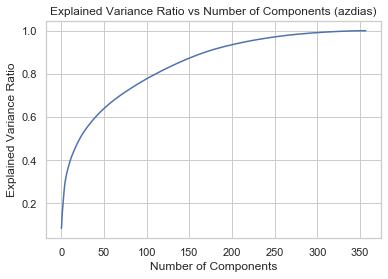

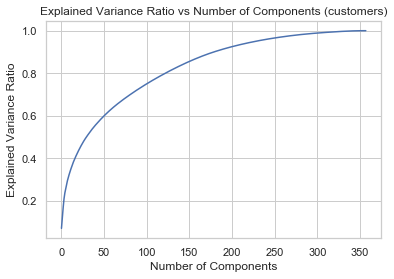

In [33]:
# create scree plots

scree_plot(azdias_pca, dataname=' (azdias)')
scree_plot(customers_pca, dataname=' (customers)')

In [34]:
# v - components_

v_azdias = azdias_pca.components_
v_customers = customers_pca.components_
v_azdias_df = pd.DataFrame(v_azdias)
v_customers_df = pd.DataFrame(v_customers)

print(v_azdias.shape)
print(v_customers.shape)
print('azdias components_: ', '\n', v_azdias_df) # v_components
print('customers components_: ', '\n', v_customers_df) # v_components

(358, 358)
(358, 358)
azdias components_:  
               0             1             2             3             4    \
0   -1.852282e-02 -2.377344e-02  7.107546e-02 -5.008842e-02  9.807542e-03   
1    7.923633e-03  1.329232e-02 -1.132257e-03 -1.702752e-02 -2.334719e-02   
2   -1.479961e-02 -7.628983e-02 -8.040755e-03  9.355613e-02  1.191273e-01   
3   -9.266177e-02  1.900440e-02 -1.452308e-02 -2.300224e-04 -1.605130e-02   
4   -3.380041e-02  1.272125e-01 -1.017294e-01 -3.147967e-03 -1.129510e-01   
..            ...           ...           ...           ...           ...   
353  2.454199e-04  3.723111e-03 -7.474925e-03  8.753457e-05  1.990647e-04   
354  4.083988e-04 -3.489909e-03 -1.564477e-03 -4.204500e-04  3.369625e-03   
355 -1.571418e-04  2.651158e-03  8.092744e-04  8.117618e-04 -1.698772e-03   
356 -1.098180e-04 -7.400459e-04 -4.668289e-03 -2.885915e-03  2.667205e-03   
357  4.861616e-17 -5.396845e-17 -1.966599e-17  1.186850e-16 -9.452790e-17   

              5             6 

In [35]:
# s - singular values

s_azdias_df = pd.DataFrame(azdias_pca.singular_values_)
s_customers_df = pd.DataFrame(customers_pca.singular_values_)

print('azdias singular_values_: ', '\n', s_azdias_df) # s_components
print('customers singular_values_: ', '\n', s_customers_df) # s_components

azdias singular_values_:  
                 0
0    4.756770e+03
1    4.425640e+03
2    3.706287e+03
3    3.514406e+03
4    3.222569e+03
..            ...
353  8.845991e+01
354  7.225957e+01
355  7.097785e+01
356  5.885980e+01
357  2.112331e-12

[358 rows x 1 columns]
customers singular_values_:  
                 0
0    1.862193e+03
1    1.578811e+03
2    1.494603e+03
3    1.410993e+03
4    1.161038e+03
..            ...
353  3.741564e+01
354  3.475285e+01
355  3.317821e+01
356  2.079069e+01
357  8.269779e-13

[358 rows x 1 columns]


In [36]:
print('azdias explained_variance_: ', '\n', azdias_pca.explained_variance_)
print('customers explained_variance_: ', '\n', customers_pca.explained_variance_ )

azdias explained_variance_:  
 [3.01457203e+01 2.60947634e+01 1.83011877e+01 1.64552713e+01
 1.38358464e+01 8.23590637e+00 7.06518630e+00 6.01608680e+00
 5.49895535e+00 5.09937165e+00 4.54655751e+00 4.36251957e+00
 3.95620647e+00 3.60820023e+00 3.48757723e+00 3.39161627e+00
 3.16096588e+00 3.08823969e+00 2.99634224e+00 2.93281153e+00
 2.72885387e+00 2.65959923e+00 2.61211542e+00 2.54500553e+00
 2.37439993e+00 2.28052892e+00 2.19366343e+00 2.02615199e+00
 2.01149840e+00 1.99596189e+00 1.95360311e+00 1.86842258e+00
 1.83602213e+00 1.81648828e+00 1.76420823e+00 1.72533741e+00
 1.71429864e+00 1.67689051e+00 1.66585053e+00 1.62283785e+00
 1.59964634e+00 1.55052500e+00 1.52562986e+00 1.46503789e+00
 1.43467788e+00 1.42189232e+00 1.40843512e+00 1.37472342e+00
 1.35006583e+00 1.33836376e+00 1.32143030e+00 1.27292998e+00
 1.25978474e+00 1.23705244e+00 1.22657121e+00 1.21759459e+00
 1.19707520e+00 1.18062121e+00 1.17129341e+00 1.14024137e+00
 1.10923598e+00 1.10061964e+00 1.09549096e+00 1.083667

 3.20085384e-03 5.06425746e-30]


In [37]:
def display_component(v, features_list, component_num, n_weights=10, dataname='N/A'):
    
    # get index of component 
    row_idx = component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[row_idx,: ] #v.iloc[:, row_idx]  <--original, but why is row_idx in col position?? This was copied from Pop_Seg
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num) + dataname)
    #print(row_idx)
    plt.show()

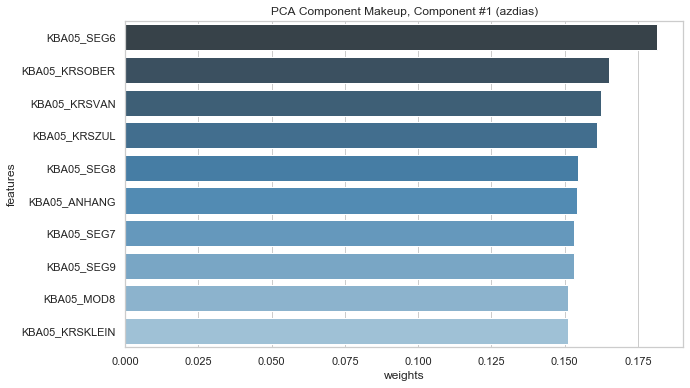

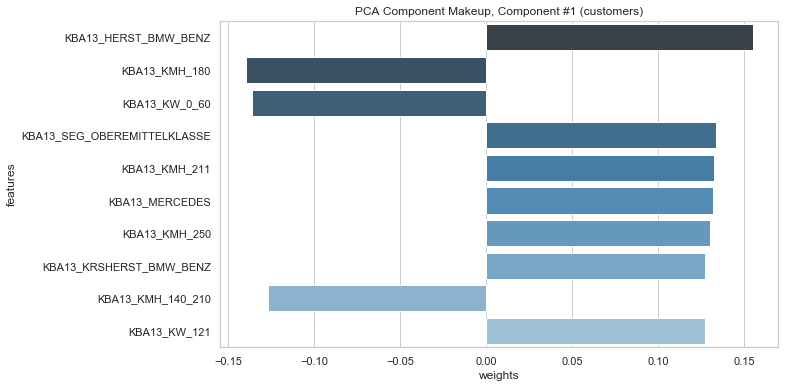

In [38]:
# this cell is to run makeup of selected component and weighting of features graph
# Note that the components are ordered from largest to smallest and so I am getting the correct rows
# by calling num=1 to get the top, 1, component, for example.

num=1
display_component(v_azdias_df, features_list_azdias, component_num=num, n_weights=10, dataname=' (azdias)')
display_component(v_customers_df, features_list_customers, component_num=num, n_weights=10, dataname=' (customers)')

In [39]:
# Design Of Experiments (DOE)

pca = PCA(n_components=358)
azdias_scaled_transformed = pca.fit_transform(azdias_scaled)
print(azdias_scaled_transformed)

[[ 4.74706472e+00 -1.98526106e+00  1.93329990e+00 ...  2.56164907e-02
  -1.12138606e-01  1.86423109e-15]
 [-2.04159406e-01 -2.42814029e-01 -2.03489573e+00 ...  4.46850787e-02
   2.92297443e-02  7.22850561e-16]
 [-3.76978835e+00  2.20184172e+00 -6.63848821e+00 ... -8.41414381e-03
  -3.90780604e-02 -3.21994176e-15]
 ...
 [-3.73033330e+00 -5.78356227e-01  2.36053047e+00 ...  1.08908822e-02
  -1.46120534e-01 -4.20607356e-16]
 [ 6.79827199e+00 -4.20918803e+00  4.05316899e+00 ... -1.01921791e-01
   5.46760765e-02  5.51777703e-16]
 [ 7.55018769e-01 -4.59933481e-02 -6.59610008e+00 ...  6.80262212e-02
   1.01595089e-02 -1.78473691e-16]]


### Unsupervised learning using MiniBatchKMeans and KMeans

I found that MiniBatchKMeans runs much faster than the standard KMeans, especially on large datasets and not much accuracy seems to be lost.

In [40]:
#KMeans (standard KMeans, but runs slow on large datasets)

'''
center = 50 # For this dataset, 20 clusters seems to be the optimal number.
kmeans = KMeans(n_clusters=center) # instantiate k-means object
kmeans_fit = kmeans.fit(azdias_scaled) # and fit the object to data
score = np.abs(kmeans_fit.score(azdias_scaled)) # i beleive this is the average distance from data point to centroid
kmeans_predict = kmeans_fit.predict(azdias_scaled) # array of the predicted cluster label values
print(score)
print(kmeans_predict)
'''

'\ncenter = 50 # For this dataset, 20 clusters seems to be the optimal number.\nkmeans = KMeans(n_clusters=center) # instantiate k-means object\nkmeans_fit = kmeans.fit(azdias_scaled) # and fit the object to data\nscore = np.abs(kmeans_fit.score(azdias_scaled)) # i beleive this is the average distance from data point to centroid\nkmeans_predict = kmeans_fit.predict(azdias_scaled) # array of the predicted cluster label values\nprint(score)\nprint(kmeans_predict)\n'

In [41]:
def kmeans_SINGLE(num_centers, data):
    '''  
    This function runs the mini_batch_kmeans or regular kmeans function on a given set of data. 
    Mini Batch KMeans runs much faster than the standard KMeans and not much accuracy is lost.
    centers - is the number of centers that you want to process
    data - is the azdias_scaled or customers_scaled data
    '''

    centers = num_centers # For this dataset, 20 clusters seems to be the optimal number.
    
    # for the two lines below, only enable one at a time by using '#'
    kmeans = MiniBatchKMeans(n_clusters=centers, random_state=1)  # instantiate mini batch k-means object
    #kmeans = KMeans(n_clusters=centers)  # instantiate mini batch k-means object
    
    kmeans_fit = kmeans.fit(data) # and fit the object to data
    score = np.abs(kmeans_fit.score(data)) # i beleive this is the average distance from data point to centroid
    kmeans_predict = kmeans_fit.predict(data) # array of the predicted cluster label values
    clusters_unique = np.unique(kmeans_predict) # this is an array of the unique cluster label values
    #print(score)
    
    return kmeans_predict, clusters_unique

In [42]:
# get kmeans prediction for azdias and customers

kmeans_predict_azdias = kmeans_SINGLE(num_centers=5, data=azdias_scaled)
kmeans_predict_customers = kmeans_SINGLE(num_centers=5, data=customers_scaled)[0]
clusters_unique = kmeans_predict_azdias[1] # choice of azdias was arbitrary since result is same for both
kmeans_predict_azdias = kmeans_predict_azdias[0]

print('kmeans_predict_azdias: ', kmeans_predict_azdias)
print('kmeans_predict_azdias shape: ', kmeans_predict_azdias.shape)
print('kmeans_predict_customers: ', kmeans_predict_customers)
print('kmeans_predict_customers shape: ', kmeans_predict_customers.shape)
print('clusters_unique: ', clusters_unique)

kmeans_predict_azdias:  [4 1 1 ... 0 2 1]
kmeans_predict_azdias shape:  (750584,)
kmeans_predict_customers:  [4 3 2 ... 4 3 2]
kmeans_predict_customers shape:  (135044,)
clusters_unique:  [0 1 2 3 4]


In [43]:
def kmeans_PLOT(data, name):
    '''  
    This function runs the mini_batch_kmeans or regular kmeans function on a given set of data. 
    Mini Batch KMeans runs much faster than the standard KMeans and not much accuracy is lost.
    centers - is the number of centers that you want to process
    data - is the azdias_scaled or customers_scaled data
    name - which dataset is it - either "General Population" or "Customers"
    '''
    
    centers_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] 
    scores = []
    
    for center in centers_list:
        # for the two lines below, only enable one at a time by using '#'
        kmeans = MiniBatchKMeans(n_clusters=center, random_state=1)  # instantiate mini batch k-means object
        #kmeans = KMeans(n_clusters=center)  # instantiate k-means object
        
        kmeans_fit = kmeans.fit(data) # and fit the object to data
        scores.append(np.abs(kmeans_fit.score(data)))
     
    #sns.set('whitegrid')
    plt.plot(centers_list, scores, linestyle=':', marker='o', color='b')
    plt.xlabel('K');
    plt.ylabel('SSE');
    plt.title('SSE vs. K %s' % name)
        
    #print(kmeans_predict)
    #print(kmeans_predict.shape)
    
    return scores

Wall time: 3min 42s


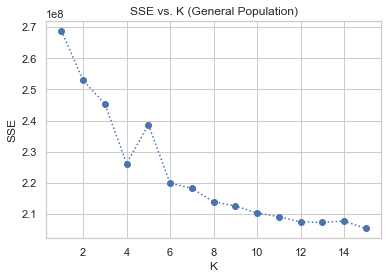

In [44]:
%%time
# mini batch kmeans plot - azdias_scaled

kmeans_scores_azdias = kmeans_PLOT(azdias_scaled, name='(General Population)')

Wall time: 49.8 s


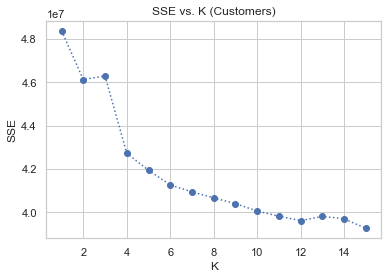

In [45]:
%%time
# mini batch kmeans plot - customers_scaled

kmeans_scores_customers = kmeans_PLOT(customers_scaled, name='(Customers)')

In [46]:
def cluster_count_plot(clusters_unique, kmeans_predict, title):
    '''  
    This function creates an array of cluster count label occurences (clusters_count) that corresponds to given dataset
    and an array of values
    clusters_unique - needs to be a 1d numpy array of the unique cluster values
    kmeans_predict - needs to be a 1d numpy array of all of the cluster label values corresponding to the data
    '''
    
    #clusters_unique = np.unique(kmeans_predict) # this is an array of the unique cluster label values
    total_length = len(kmeans_predict)
    clusters_unique_len = len(clusters_unique)
    clusters_count = []
    clusters_percent = []
    clusters_count_full = []
    sns.set(style="whitegrid")
    
    for i in range(clusters_unique_len):
            result = np.where(kmeans_predict == i) # creates array of all the locations for that particular 'i' cluster label value
            result = np.asarray(result) # convert to array
            result = result.size # get size of array e.g. number of occurences
            clusters_count.append(result) #append size in respective cluster label order -> 0, 1, 2...19
            clusters_count_full.append(result)
            
    clusters_count = [float(i) for i in clusters_count]
    clusters_percent.append([float((x/total_length)*100) for x in clusters_count])
    clusters_count = list(clusters_count)[0]
    clusters_percent = list(clusters_percent)[0]
    
    y_pos = np.asarray(clusters_unique)
    performance = np.asarray(clusters_percent)
    '''
    # bar graph - percentage of total vs cluster
    #plt.bar(y_pos, performance, align='center', alpha=0.75)
    sns.barplot(x=y_pos, y=performance, palette='hls', alpha=0.90)
    plt.xticks(y_pos, clusters_unique)
    plt.xlabel('Cluster')
    plt.ylabel('Percentage of Total (%)')
    plt.title(title)
    clusters_percent_1d = ['%.1f' % elem for elem in clusters_percent]
    
    plot = plt.show()
    '''
    
    return clusters_count_full, clusters_percent

In [47]:
%%time
# run cluster_count_plot function on general population data (kmeans_predict_azdias)
# and customers data (kmeans_predict_customers)

clusters_unique_mod = clusters_unique
clus_func_azdias = cluster_count_plot(clusters_unique_mod, kmeans_predict_azdias, 'General Population') 
clus_func_customers = cluster_count_plot(clusters_unique_mod, kmeans_predict_customers, 'Customers') 

Wall time: 47 ms


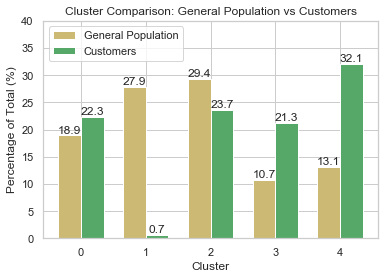

In [48]:
# plots cluster results together
# code resued from matplotlib example: https://matplotlib.org/examples/api/barchart_demo.html

N = 5
ind = np.arange(N)
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(ind, clus_func_azdias[1], width, color='y') 
rects2 = ax.bar(ind + width, clus_func_customers[1], width, color='g')

ax.set_xlabel('Cluster')
ax.set_ylabel('Percentage of Total (%)')
ax.set_title('Cluster Comparison: General Population vs Customers')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('0', '1', '2', '3', '4'))
ax.legend((rects1[0], rects2[0]), ('General Population', 'Customers'), loc='upper left' )

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.set_ylim([0,40])
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height, '%.1f' % float(height), ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [49]:
'''
# calculate and plot ratio of customers to general population for each cluster
c = clus_func_customers[1]
a = clus_func_azdias[1]
ratio = [c / a for c,a in zip(c, a)] # use list comprehension to do ratio math
y_pos = np.asarray(clusters_unique_mod)
    
# bar graph - ratio of customers to general population
#plt.bar(y_pos, ratio, align='center', alpha=0.75)
sns.barplot(x=y_pos, y=ratio, palette='hls', alpha=0.90)
plt.xticks(y_pos, clusters_unique_mod)
plt.xlabel('Cluster')
plt.ylabel('Ratio (Customers/General Population)')
plt.title('Ratio of Customers to General Population')

plot = plt.show()
ratio = ['%.1f' % elem for elem in ratio]
print(ratio)
'''

"\n# calculate and plot ratio of customers to general population for each cluster\nc = clus_func_customers[1]\na = clus_func_azdias[1]\nratio = [c / a for c,a in zip(c, a)] # use list comprehension to do ratio math\ny_pos = np.asarray(clusters_unique_mod)\n    \n# bar graph - ratio of customers to general population\n#plt.bar(y_pos, ratio, align='center', alpha=0.75)\nsns.barplot(x=y_pos, y=ratio, palette='hls', alpha=0.90)\nplt.xticks(y_pos, clusters_unique_mod)\nplt.xlabel('Cluster')\nplt.ylabel('Ratio (Customers/General Population)')\nplt.title('Ratio of Customers to General Population')\n\nplot = plt.show()\nratio = ['%.1f' % elem for elem in ratio]\nprint(ratio)\n"

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [50]:
# *do only when running in Udacity environment*
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [51]:
# *run only when in local environment*
mailout_train = pd.read_csv(r'C:\Users\amiri\OneDrive\Education\MLND\Capstone Project\Notebooks\mailout_train.csv')

C:\Users\amiri\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [52]:
# view data
print(mailout_train.shape)
mailout_train.head()

(42962, 367)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [53]:
# get train labels

train_labels = mailout_train['RESPONSE'].tolist()

In [54]:
# run data_preprocess_clean function
missing_rows_train = inspect_rows(mailout_train, missing_percent_row=30)
mailout_train_clean = data_preprocess_clean(mailout_train, operation='both', delete_rows=missing_rows_train)
mailout_train_clean_mod = mailout_train_clean # need a df with RESPONSE column
mailout_train_clean_mod.head()

Number of rows missing >=  30%:  8778
Percent of missing to total:  20.432009682975654

- processing columns
rows, columns (before):  (42962, 367)
rows, columns (after):  (42962, 361)
- processing rows
rows, columns (before):  (42962, 361)
rows, columns (after):  (34184, 361)
- filling empty cells with most frequent value for each column
- one hot encoding for OST_WEST_KZ and CAMEO_DEU_2015
- replacing "X" and "XX" in CAMEO_DEU_2015 column w/most frequent of column
- replacing "X" and "XX" in CAMEO_DEUG_2015 column w/most frequent of column
- replacing "X" and "XX" in CAMEO_INTL_2015 column w/most frequent of column


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,7.0,0.0,0.0,0.0,0.0,1.0,...,6.0,4.0,2.0,6.0,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [55]:
#mailout_train_clean.to_csv('mailout_train_clean_3.csv', index=False)

In [56]:
# mailout_train_clean - list of remaining features

mailout_train_clean = mailout_train_clean.drop(['RESPONSE'], inplace=False, axis=1)
features_list_train = mailout_train_clean.columns.values
print(type(features_list_train))
print('number of remaining features (mailout_train): ', len(features_list_train))
print('Features: \n', features_list_train)

<class 'numpy.ndarray'>
number of remaining features (mailout_train):  358
Features: 
 ['LNR' 'AGER_TYP' 'AKT_DAT_KL' 'ALTER_HH' 'ALTERSKATEGORIE_FEIN'
 'ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL' 'ANZ_KINDER' 'ANZ_PERSONEN'
 'ANZ_STATISTISCHE_HAUSHALTE' 'ANZ_TITEL' 'ARBEIT' 'BALLRAUM'
 'CAMEO_DEU_2015' 'CAMEO_DEUG_2015' 'CAMEO_INTL_2015' 'CJT_GESAMTTYP'
 'CJT_KATALOGNUTZER' 'CJT_TYP_1' 'CJT_TYP_2' 'CJT_TYP_3' 'CJT_TYP_4'
 'CJT_TYP_5' 'CJT_TYP_6' 'D19_BANKEN_ANZ_12' 'D19_BANKEN_ANZ_24'
 'D19_BANKEN_DATUM' 'D19_BANKEN_DIREKT' 'D19_BANKEN_GROSS'
 'D19_BANKEN_LOKAL' 'D19_BANKEN_OFFLINE_DATUM' 'D19_BANKEN_ONLINE_DATUM'
 'D19_BANKEN_ONLINE_QUOTE_12' 'D19_BANKEN_REST' 'D19_BEKLEIDUNG_GEH'
 'D19_BEKLEIDUNG_REST' 'D19_BILDUNG' 'D19_BIO_OEKO' 'D19_BUCH_CD'
 'D19_DIGIT_SERV' 'D19_DROGERIEARTIKEL' 'D19_ENERGIE' 'D19_FREIZEIT'
 'D19_GARTEN' 'D19_GESAMT_ANZ_12' 'D19_GESAMT_ANZ_24' 'D19_GESAMT_DATUM'
 'D19_GESAMT_OFFLINE_DATUM' 'D19_GESAMT_ONLINE_DATUM'
 'D19_GESAMT_ONLINE_QUOTE_12' 'D19_HANDWERK' 'D19_HAU

In [57]:
equal = collections.Counter(features_list_azdias) == collections.Counter(features_list_train)
print('features lists of azdias == customers == mailout_train?: ', equal)

features lists of azdias == customers == mailout_train?:  True


In [58]:
# create list of 1's for customer only data that is to be appended to mailout data

response = [1]*len(customers_clean) # create list of 1's for response column since these are for response column of customers
response_az = [0]*len(azdias_clean) #create list of 0's for response column 

In [59]:
# create and add RESPONSE column to end of customers df

customers_clean_mod = customers_clean
customers_clean_mod['RESPONSE'] = response

azdias_clean_mod = azdias_clean
azdias_clean_mod['RESPONSE'] = response_az

In [60]:
'''
# take data from the 'customers' file and add some of that data to 'mailout' data
# also experiemented with adding azdias data as well, labeled them as non-customers (0's)

#azdias_clean_shuff = azdias_clean.sample(frac=1)

customers_clean_shuff = customers_clean.sample(frac=1) #shuffle data
rows = int(len(mailout_train_clean) * 0.0124) # number can be from 0 to 1
print(rows)

customers_clean_shuff = customers_clean_shuff.iloc[0:rows, ] # take some rows, add to data
#azdias_clean_shuff = azdias_clean_shuff.iloc[0:rows, ] # take some rows, add to data
print(customers_clean_shuff.shape)
customers_clean_shuff.head()
'''

"\n# take data from the 'customers' file and add some of that data to 'mailout' data\n# also experiemented with adding azdias data as well, labeled them as non-customers (0's)\n\n#azdias_clean_shuff = azdias_clean.sample(frac=1)\n\ncustomers_clean_shuff = customers_clean.sample(frac=1) #shuffle data\nrows = int(len(mailout_train_clean) * 0.0124) # number can be from 0 to 1\nprint(rows)\n\ncustomers_clean_shuff = customers_clean_shuff.iloc[0:rows, ] # take some rows, add to data\n#azdias_clean_shuff = azdias_clean_shuff.iloc[0:rows, ] # take some rows, add to data\nprint(customers_clean_shuff.shape)\ncustomers_clean_shuff.head()\n"

In [61]:
'''
# append some of the customer only data to the mailout data, this to balance out the dataset 

#mailout_train_clean_mod = mailout_train_clean_mod.append(customers_clean_shuff)
#mailout_train_clean_mod = mailout_train_clean_mod.append(azdias_clean_shuff)
#mailout_train_clean_mod = mailout_train_clean_mod.sample(frac=1)

print(mailout_train_clean_mod.shape)
mailout_train_clean_mod.head()
'''

'\n# append some of the customer only data to the mailout data, this to balance out the dataset \n\n#mailout_train_clean_mod = mailout_train_clean_mod.append(customers_clean_shuff)\n#mailout_train_clean_mod = mailout_train_clean_mod.append(azdias_clean_shuff)\n#mailout_train_clean_mod = mailout_train_clean_mod.sample(frac=1)\n\nprint(mailout_train_clean_mod.shape)\nmailout_train_clean_mod.head()\n'

In [62]:
# Calculate the fraction of data points that are customers
def customer_percentage(transaction_df):
    '''Calculate the fraction of all data points that have a 'RESPONSE' label of 1; customer.
       :param transaction_df: Dataframe of all transaction data points; has a column 'Class'
       :return: A fractional percentage of fraudulent data points/all points
    '''
    # counts for all responses
    counts = transaction_df['RESPONSE'].value_counts()
    
    # get customer and non-customer cnts
    cust_cnts = counts[1]
    non_cust_cnts = counts[0]
    
    # calculate percentage of customer data
    customer_percentage = cust_cnts/(cust_cnts+non_cust_cnts)
    
    return customer_percentage

In [63]:
# call the function to calculate the customer percentage
transaction_df=mailout_train_clean_mod
cust_percentage = customer_percentage(transaction_df)

print('Customer percentage = ', cust_percentage)
print('Total # of customer pts: ', cust_percentage*transaction_df.shape[0])
print('Out of (total) pts: ', transaction_df.shape[0])

Customer percentage =  0.012403463608705827
Total # of customer pts:  424.0
Out of (total) pts:  34184


In [64]:
# split into train/test
def train_test_split(transaction_df, train_frac= 0.7, seed=1):
    '''Shuffle the data and randomly split into train and test sets;
       separate the class labels (the column in transaction_df) from the features.
       :param df: Dataframe of all credit card transaction data
       :param train_frac: The decimal fraction of data that should be training data
       :param seed: Random seed for shuffling and reproducibility, default = 1
       :return: Two tuples (in order): (train_features, train_labels), (test_features, test_labels)
       '''
    
    # convert the df into a matrix for ease of splitting
    df_matrix = transaction_df.as_matrix()
    
    # shuffle the data
    np.random.seed(seed)
    np.random.shuffle(df_matrix)
    
    # split the data
    train_size = int(df_matrix.shape[0] * train_frac)
    # features are all but last column
    train_features  = df_matrix[:train_size, :-1]
    # class labels *are* last column
    train_labels = df_matrix[:train_size, -1]
    # test data
    test_features = df_matrix[train_size:, :-1]
    test_labels = df_matrix[train_size:, -1]
    
    return (train_features, train_labels), (test_features, test_labels)


In [65]:
# make RESOURCE column the last column
cols = list(transaction_df.columns.values)  # make a list of all columns
cols.pop(cols.index('RESPONSE')) # remove RESPONSE from list
transaction_df = transaction_df[cols+['RESPONSE']] # create new dataframe with RESPONSE as last column
#mailout_train_clean_mod.columns.values

# call train_test_split function
train_test_split(transaction_df, train_frac= 0.7, seed=1)


C:\Users\amiri\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


((array([[83627, -1, 5.0, ..., 3, 2, 4],
         [75135, -1, 1.0, ..., 1, 2, 3],
         [67941, -1, 1.0, ..., 3, 2, 4],
         ...,
         [49834, 2, 1.0, ..., 3, 2, 4],
         [62027, 2, 7.0, ..., 3, 2, 4],
         [32622, 1, 1.0, ..., 3, 2, 4]], dtype=object),
  array([0, 0, 0, ..., 0, 0, 0], dtype=object)),
 (array([[38709, 3, 6.0, ..., 3, 2, 3],
         [65730, 2, 1.0, ..., 3, 2, 4],
         [68028, 1, 1.0, ..., 3, 1, 3],
         ...,
         [65029, -1, 1.0, ..., 6, 2, 3],
         [35065, 1, 1.0, ..., 1, 2, 3],
         [79060, 1, 1.0, ..., 3, 2, 4]], dtype=object),
  array([0, 0, 0, ..., 0, 0, 0], dtype=object)))

In [66]:
# get train/test data
(train_features, train_labels), (test_features, test_labels) = train_test_split(transaction_df, train_frac=0.7)

# conversion
train_features = np.asarray(train_features, dtype=np.float64)
train_labels = train_labels.astype('int') # get errors without this
test_features = np.asarray(test_features, dtype=np.float64)
test_labels = test_labels.astype('int') # get errors without this

C:\Users\amiri\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [67]:
# manual test; code below is to check that results from function above make sense

# for a split of 0.7:0.3 there should be ~2.33x as many training as test pts
print('Training data pts: ', len(train_features))
print('Test data pts: ', len(test_features))
print()

# take a look at first item and see that it aligns with first row of data
print('First item: \n', train_features[0])
print('Label: ', train_labels[0])
print()

# test split
assert len(train_features) > 2.333*len(test_features), \
        'Unexpected number of train/test points for a train_frac=0.7'
# test labels
assert np.all(train_labels)== 0 or np.all(train_labels)== 1, \
        'Train labels should be 0s or 1s.'
assert np.all(test_labels)== 0 or np.all(test_labels)== 1, \
        'Test labels should be 0s or 1s.'
print('Tests passed!')

Training data pts:  23928
Test data pts:  10256

First item: 
 [ 8.3627e+04 -1.0000e+00  5.0000e+00  1.4000e+01  1.4000e+01  1.0000e+00
  0.0000e+00  0.0000e+00  3.0000e+00  1.0000e+00  0.0000e+00  2.0000e+00
  4.0000e+00  1.1000e+01  3.0000e+00  2.4000e+01  4.0000e+00  1.0000e+00
  3.0000e+00  3.0000e+00  4.0000e+00  4.0000e+00  4.0000e+00  3.0000e+00
  0.0000e+00  0.0000e+00  1.0000e+01  0.0000e+00  0.0000e+00  0.0000e+00
  1.0000e+01  1.0000e+01  0.0000e+00  0.0000e+00  3.0000e+00  6.0000e+00
  5.0000e+00  6.0000e+00  5.0000e+00  5.0000e+00  6.0000e+00  0.0000e+00
  6.0000e+00  6.0000e+00  2.0000e+00  4.0000e+00  2.0000e+00  2.0000e+00
  5.0000e+00  5.0000e+00  6.0000e+00  5.0000e+00  6.0000e+00  1.0000e+00
  2.0000e+00  6.0000e+00  6.0000e+00  7.0000e+00  3.0000e+00  6.0000e+00
  6.0000e+00  6.0000e+00  0.0000e+00  3.0000e+00  1.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  9.0000e+00  0.0000e+00  1.0000e+01  1.0000e+01
  0.0000e+00  6.0000e+00  0.0000e+00  2.0000e+00  4.0000e+00 

In [68]:
# over/under sampling experimentation

# oversample using SMOTE (Synthetic Minority Oversampling Technique)
# oversampling after splitting the data is the correct implementation

sm = SMOTE(ratio=1) #random_state=1, ratio = 1
#train_features, train_labels = sm.fit_resample(train_features, train_labels)

rus = RandomUnderSampler(ratio=1) #sampling_strategy=float, ratio=1, random_state=42
#train_features, train_labels = rus.fit_resample(train_features, train_labels)

nm = NearMiss(random_state=42)
#train_features, train_labels = nm.fit_sample(train_features, train_labels)

smk = SMOTETomek(random_state=42)
#train_features, train_labels = smk.fit_sample(train_features, train_labels)

train_features.shape, train_labels.shape

((23928, 358), (23928,))

In [69]:
# Random forest classifier - fit estimator with training data/labels; for benchmark model

'''
clf = RandomForestClassifier(n_estimators=1000) 
print(cclf)
start = time.time()
clf_fit =clf.fit(train_features, train_labels)
end = time.time()
print('wall time (s): ', end - start)
print(clf_fit)
print()

fi = pd.DataFrame({'Feature': features_list_train, 'Importance': clf_fit.feature_importances_}).\
sort_values('Importance', ascending = False)
fi.head(10)
'''

"\nclf = RandomForestClassifier(n_estimators=1000) \nprint(cclf)\nstart = time.time()\nclf_fit =clf.fit(train_features, train_labels)\nend = time.time()\nprint('wall time (s): ', end - start)\nprint(clf_fit)\nprint()\n\nfi = pd.DataFrame({'Feature': features_list_train, 'Importance': clf_fit.feature_importances_}).sort_values('Importance', ascending = False)\nfi.head(10)\n"

In [70]:
# XGBoost - fit estimator with training data/labels
'''
clf = XGBClassifier(n_estimators=1000)
start = time.time()
clf_fit =clf.fit(train_features, train_labels)
end = time.time()
print('wall time (s): ', end - start)
print(clf_fit)
print()

fi = pd.DataFrame({'Feature': features_list_train, 'Importance': clf_fit.feature_importances_}).\
sort_values('Importance', ascending = False)
fi.head(10)
'''

"\nclf = XGBClassifier(n_estimators=1000)\nstart = time.time()\nclf_fit =clf.fit(train_features, train_labels)\nend = time.time()\nprint('wall time (s): ', end - start)\nprint(clf_fit)\nprint()\n\nfi = pd.DataFrame({'Feature': features_list_train, 'Importance': clf_fit.feature_importances_}).sort_values('Importance', ascending = False)\nfi.head(10)\n"

In [71]:
# Gradient boosting classifier - fit estimator with training data/labels
'''
clf = GradientBoostingClassifier(n_estimators=100) #n_estimators=1000
start = time.time()
clf_fit =clf.fit(train_features, train_labels) # ***disable when using StratifiedKFold***
end = time.time()
print('wall time (s): ', end - start)
print(clf_fit)
print()

fi = pd.DataFrame({'Feature': features_list_train, 'Importance': clf_fit.feature_importances_}).\
sort_values('Importance', ascending = False)
fi.head(10)
'''

"\nclf = GradientBoostingClassifier(n_estimators=100) #n_estimators=1000\nstart = time.time()\nclf_fit =clf.fit(train_features, train_labels) # ***disable when using StratifiedKFold***\nend = time.time()\nprint('wall time (s): ', end - start)\nprint(clf_fit)\nprint()\n\nfi = pd.DataFrame({'Feature': features_list_train, 'Importance': clf_fit.feature_importances_}).sort_values('Importance', ascending = False)\nfi.head(10)\n"

In [72]:
param_grid = {
    'learning_rate': [0.04,0.05,0.06],
    'n_estimators': [60, 70, 80],
    'max_depth': [1, 2, 3]
}

from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

clf = LGBMRegressor(n_estimators=10) 
clf = GridSearchCV(clf, param_grid, cv=3)

start = time.time()
clf_fit =clf.fit(train_features, train_labels)
end = time.time()
print('wall time (s): ', end - start)
print(clf_fit)
print()

print('Best parameters found by grid search are:', clf.best_params_)
print('Best score found by grid search are:', clf.best_score_)


wall time (s):  115.26200079917908
GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=10, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.04, 0.05, 0.06],
                         'max_depth': [1, 2, 3], 'n_estimators': [60, 70, 

In [73]:
# LGBMRegressor - fit estimator with training data/labels

from lightgbm import LGBMRegressor
clf = LGBMRegressor(learning_rate=0.05, max_depth=2, n_estimators=70) # parameters selected through grid search
start = time.time()
clf_fit =clf.fit(train_features, train_labels)
end = time.time()
print('wall time (s): ', end - start)
print(clf_fit)
print()

fi = pd.DataFrame({'Feature': features_list_train, 'Importance': clf_fit.feature_importances_}).\
sort_values('Importance', ascending = False)
fi.head(10)


wall time (s):  1.7751731872558594
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=2,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=70, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)



,Feature,Importance
64,D19_SOZIALES,56
54,D19_KONSUMTYP_MAX,26
162,KBA05_SEG2,16
347,VHA,6
13,CAMEO_DEU_2015,6
340,STRUKTURTYP,6
5,ANZ_HAUSHALTE_AKTIV,6
3,ALTER_HH,5
332,SEMIO_PFLICHT,5
126,KBA05_CCM4,4


In [74]:
# LGBMClassifier - fit estimator with training data/labels
'''
from lightgbm import LGBMClassifier
clf = LGBMClassifier(n_estimators=100) #n_estimators=2000, learning_rate=0.001
start = time.time()
clf_fit =clf.fit(train_features, train_labels)
end = time.time()
print('wall time (s): ', end - start)
print(clf_fit)
print()

fi = pd.DataFrame({'Feature': features_list_train, 'Importance': clf_fit.feature_importances_}).\
sort_values('Importance', ascending = False)
fi.head(10)
'''

"\nfrom lightgbm import LGBMClassifier\nclf = LGBMClassifier(n_estimators=100) #n_estimators=2000, learning_rate=0.001\nstart = time.time()\nclf_fit =clf.fit(train_features, train_labels)\nend = time.time()\nprint('wall time (s): ', end - start)\nprint(clf_fit)\nprint()\n\nfi = pd.DataFrame({'Feature': features_list_train, 'Importance': clf_fit.feature_importances_}).sort_values('Importance', ascending = False)\nfi.head(10)\n"

In [75]:
# implement StratifiedKFold, because the data is highly imbalanced
'''
from sklearn.model_selection import StratifiedKFold
#X_train = train_features
#X_test = test_features
#y_train = train_labels
#y_test = test_labels
X = pd.DataFrame(train_features)
Y = pd.DataFrame(train_labels)

roc_auc=[]
skf = StratifiedKFold(n_splits=4, random_state=None)
skf.get_n_splits(X, Y)
print(skf)
# X is the feature set and Y is the target
for train_index, test_index in skf.split(X, Y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X1_train, X1_test = X.iloc[train_index], X.iloc[test_index]
    y1_train, y1_test = Y.iloc[train_index], Y.iloc[test_index]
    
    clf.fit(X1_train, y1_train)
    prediction=clf.predict(X1_test)
    score= roc_auc_score(y1_test, prediction) #changed
    roc_auc.append(score)
print(roc_auc)
print(roc_auc)
np.array(roc_auc).mean()
'''

'\nfrom sklearn.model_selection import StratifiedKFold\n#X_train = train_features\n#X_test = test_features\n#y_train = train_labels\n#y_test = test_labels\nX = pd.DataFrame(train_features)\nY = pd.DataFrame(train_labels)\n\nroc_auc=[]\nskf = StratifiedKFold(n_splits=4, random_state=None)\nskf.get_n_splits(X, Y)\nprint(skf)\n# X is the feature set and Y is the target\nfor train_index, test_index in skf.split(X, Y):\n    print("TRAIN:", train_index, "TEST:", test_index)\n    X1_train, X1_test = X.iloc[train_index], X.iloc[test_index]\n    y1_train, y1_test = Y.iloc[train_index], Y.iloc[test_index]\n    \n    clf.fit(X1_train, y1_train)\n    prediction=clf.predict(X1_test)\n    score= roc_auc_score(y1_test, prediction) #changed\n    roc_auc.append(score)\nprint(roc_auc)\nprint(roc_auc)\nnp.array(roc_auc).mean()\n'

In [76]:
# run predictor on fitted data

clf_predictions = clf_fit.predict(test_features)
clf_predictions = pd.DataFrame(clf_predictions)
clf_predictions.columns = clf_predictions.columns=['predicted_label']
print('predicted counts, 1=customer: \n', clf_predictions['predicted_label'].value_counts())
print()

df_labels = pd.DataFrame(test_labels)
df_labels.columns = df_labels.columns=['test_labels']
print('test_labels counts, 1=customer: \n', df_labels['test_labels'].value_counts())

clf_predictions = clf_predictions['predicted_label']
print(clf_predictions.shape)
print(test_labels.shape)

predicted counts, 1=customer: 
 0.005076    16
0.028575    13
0.029586    13
0.029888    13
0.030658    13
            ..
0.031711     1
0.006066     1
0.030029     1
0.007938     1
0.003424     1
Name: predicted_label, Length: 8622, dtype: int64

test_labels counts, 1=customer: 
 0    10139
1      117
Name: test_labels, dtype: int64
(10256,)
(10256,)


In [77]:
# return random forest score and roc_auc score

clf_prob = clf_predictions # enable this line for LGBMRegressor, disable for rest
#clf_prob = clf_fit.predict_proba(test_features) # disable this line for LGBMRegressor

#clf_prob = clf_prob[:,1] # disable this line when doing LGBMRegressor
roc_value = roc_auc_score(test_labels, clf_prob)

#print('Scores:')
#print(' Accuracy: ', clf_fit.score(test_features, test_labels)) # mean accuracy of the given test data/labels
#print(' Recall: ', recall_score(test_labels, clf_predictions, average= 'binary' ))
#print(' Precison: ', precision_score(test_labels, clf_predictions))
print(' ROC AUC: ',roc_value)


 ROC AUC:  0.7835981565639323


In [78]:
# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate(test_preds, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # printing a table of metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}


In [79]:
print('Metrics for model.\n')

# get metrics for model
clf_predictions_round = round(clf_predictions)
#test_features_round = round(test_features)
metrics = evaluate(clf_predictions_round, 
                   test_labels, 
                   verbose=True) # verbose means we'll print out the metrics
print(metrics)

Metrics for model.

prediction (col)    0.0
actual (row)           
0                 10139
1                   117

Recall:     0.000
Precision:  nan
Accuracy:   0.989

{'TP': 0, 'FP': 0, 'FN': 117, 'TN': 10139, 'Precision': nan, 'Recall': 0.0, 'Accuracy': 0.9885920436817472}


C:\Users\amiri\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars


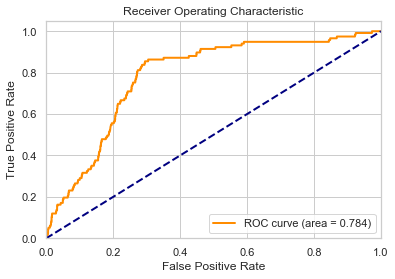

In [80]:
# graph roc auc

fpr, tpr, thresholds = roc_curve(test_labels, clf_prob)
auc_a = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % auc_a )
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [81]:
# correlate RESPONSE column with itself
'''
corr = mailout_train_clean_mod.corr()['RESPONSE'][mailout_train_clean_mod.corr()['RESPONSE'] < 1].abs()
corr = pd.DataFrame(corr)
corr.sort_values(by=['RESPONSE'], ascending=False)
print(len(corr))
corr.head(20)
'''

"\ncorr = mailout_train_clean_mod.corr()['RESPONSE'][mailout_train_clean_mod.corr()['RESPONSE'] < 1].abs()\ncorr = pd.DataFrame(corr)\ncorr.sort_values(by=['RESPONSE'], ascending=False)\nprint(len(corr))\ncorr.head(20)\n"

In [82]:
# using SelectFromModel - BETA, JUST MESSING AROUND HERE

'''
# ***only run one at a time***
#sel = SelectFromModel(RandomForestClassifier(n_estimators=1000))
#sel = SelectFromModel(XGBClassifier(n_estimators=1000))
sel = SelectFromModel(GradientBoostingClassifier(n_estimators=1000))
sel.fit(train_features, train_labels)

#sel.get_support()
train_features_df = pd.DataFrame(train_features)
selected_feat = train_features_df.columns[(sel.get_support())]
print('number of selected features: ', len(selected_feat))
print(selected_feat)
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()
train_features_df.head()
'''

"\n# ***only run one at a time***\n#sel = SelectFromModel(RandomForestClassifier(n_estimators=1000))\n#sel = SelectFromModel(XGBClassifier(n_estimators=1000))\nsel = SelectFromModel(GradientBoostingClassifier(n_estimators=1000))\nsel.fit(train_features, train_labels)\n\n#sel.get_support()\ntrain_features_df = pd.DataFrame(train_features)\nselected_feat = train_features_df.columns[(sel.get_support())]\nprint('number of selected features: ', len(selected_feat))\nprint(selected_feat)\npd.Series(sel.estimator_.feature_importances_.ravel()).hist()\ntrain_features_df.head()\n"

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [83]:
# *run only when in Udacity environment
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [84]:
# *run only when in local environment*
mailout_test = pd.read_csv(r'C:\Users\amiri\OneDrive\Education\MLND\Capstone Project\Notebooks\mailout_test.csv')

C:\Users\amiri\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [85]:
# preprocess and clean
missing_rows_test = inspect_rows(mailout_test, missing_percent_row=20)
mailout_test_clean = data_preprocess_clean(mailout_test, operation='col', delete_rows=None)
#mailout_test_clean = mailout_test.dropna(inplace=False, axis=1)
mailout_test_clean.shape

Number of rows missing >=  20%:  9213
Percent of missing to total:  21.50911680246539

- processing columns
rows, columns (before):  (42833, 366)
rows, columns (after):  (42833, 360)
- filling empty cells with most frequent value for each column
- one hot encoding for OST_WEST_KZ and CAMEO_DEU_2015
- replacing "X" and "XX" in CAMEO_DEU_2015 column w/most frequent of column
- replacing "X" and "XX" in CAMEO_DEUG_2015 column w/most frequent of column
- replacing "X" and "XX" in CAMEO_INTL_2015 column w/most frequent of column


(42833, 358)

In [86]:
#mailout_test_clean.to_csv('mailout_test_clean.csv', index=False)

In [87]:
# make sure remaining features match those used previously

features_list_test = mailout_test_clean.columns.values
equal_all = collections.Counter(features_list_azdias) == collections.Counter(features_list_test)
print('features lists of azdias == customers == mailout_train == mailout_test?: ', equal_all)

features lists of azdias == customers == mailout_train == mailout_test?:  True


In [88]:
#mailout_test_clean = mailout_test_clean.to_numpy()
mailout_test_clean = np.array(mailout_test_clean)
print(type(mailout_test_clean))
print(mailout_test_clean.shape)

<class 'numpy.ndarray'>
(42833, 358)


In [89]:
# run predictor and return probability (of a 1 or 0) for each data point (row)

# below - ***only run one at a time***
#response = clf_fit.predict_proba(mailout_test_clean)[:,1] # for RandomForestClassifier, GradientBoostClassifier
response = clf_fit.predict(mailout_test_clean) # for XGBoost, LGBMRegressor
print(response)
#response = response[:,1]

[0.02984927 0.02971571 0.00899536 ... 0.02459333 0.02483529 0.02832013]


In [90]:
lnr = pd.DataFrame(mailout_test['LNR'])
print(lnr.shape)
response = pd.DataFrame(response)
print(response.shape)
response = response.rename(columns={0: 'RESPONSE'})
frames = [lnr, response]
submission = pd.concat(frames, sort=False, axis=1)
submission.to_csv('submission.csv', index=False)
print(submission.shape)
submission.head()

(42833, 1)
(42833, 1)
(42833, 2)


,LNR,RESPONSE
0,1754,0.029849
1,1770,0.029716
2,1465,0.008995
3,1470,0.008335
4,1478,0.003874


In [91]:
# round RESPONSE column so that they are either 0/1

submission_rnd = [round(value) for value in submission['RESPONSE']]
submission_rnd = pd.DataFrame(submission_rnd)
print(type(submission_rnd))
print('RESPONSE counts, 1=customer: \n',submission_rnd[0].value_counts())
submission_rnd.head()

<class 'pandas.core.frame.DataFrame'>
RESPONSE counts, 1=customer: 
 0    42833
Name: 0, dtype: int64


,0
0,0
1,0
2,0
3,0
4,0
